In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *
import torchvision.models as tmodels

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.misc import imsave

In [3]:
import pandas as pd
truthFile = '/home/santhosr/Documents/Birad/birad_targetFile.csv'
truth = pd.read_csv(truthFile)

#### Helper Functions

In [54]:
def getTestAccuracy(model, data):
    
    predList2 = []
    target = []
    patientIDList = []
    viewList = []

    for i in tqdm(range(len(data.valid_ds.x))):
        p = model.predict(data.valid_ds.x[i])
        name = data.valid_ds.x.items[i].name
        
        if len(name.split("_"))==5:
            patientID = name.split("_")[1]
        else:
            patientID = name.split("_")[0]
        
        if 'MLO' in name:
            viewList.append('MLO')
        else:
            viewList.append('CC')
        
        predList2.append(p)
        target.append(int(data.valid_ds.y[i]))
        patientIDList.append(patientID)
    
    predClass = [int(i[1].numpy()) for i in predList2]
    
    df = pd.DataFrame({'target':target,'pred2':predClass,'patientID':patientIDList,'view':viewList})
    
    errors = len(df[df.target != df.pred2])
    acc = (len(target)-errors)/len(target)
    print("Validation accuracy : {}".format(acc))
    
    return df, acc

def checkPatientOverlap(data1,data2):
    
    patientIDList1 = []
    patientIDList2 = []
    
    for i in range(len(data1.x.items)):
        name = data1.x.items[i].name
        
        if len(name.split("_"))==5:
            patientID = name.split("_")[1]
        else:
            patientID = name.split("_")[0]
        
        patientIDList1.append(patientID)
        
    for i in range(len(data2.x.items)):
        name = data2.x.items[i].name
        
        if len(name.split("_"))==5:
            patientID = name.split("_")[1]
        else:
            patientID = name.split("_")[0]
        
        patientIDList2.append(patientID)
        
    patientIDList1 = set(patientIDList1)
    patientIDList2 = set(patientIDList2)
    
    commonPatients = list(patientIDList1.intersection(patientIDList2))
    
    patientIDList1 = list(patientIDList1)
    patientIDList2 = list(patientIDList2)
        
    
    return commonPatients, patientIDList1, patientIDList2
        

In [67]:
def getValidAccuracy( data, model=None, pred = None):
    
    if pred == None:
        pred = model.get_preds(data.valid_ds)
        
    common,trainList,validList = checkPatientOverlap(data.train_ds, data.valid_ds)
    inTrain=[]
    patientIDList=[]
    
    for i in range(len(data.valid_ds)):
        name = data.valid_ds.x.items[i].name
        
        if len(name.split("_"))==5:
            patientID = name.split("_")[1]
        else:
            patientID = name.split("_")[0]
        
        patientIDList.append(patientID)
        
        if patientID in trainList:
            inTrain.append(True)
        else:
            inTrain.append(False)
    
    target = pred[1].numpy()
    finalPred = np.argmax(pred[0].numpy(),1)
    score = accuracy_score(finalPred,target)
    
    df = pd.DataFrame({'target':target,'pred':finalPred,'ID':patientIDList,'inTrain':inTrain})
    
    totalNew = len(df[df.inTrain==False])
    totalNewCorrect = len(df[(df.inTrain==False) & (df.target == df.pred) ])
    newAccuracy = totalNewCorrect/totalNew
    
    
    print("Test images : {} Accuracy : {} Unseen Data Accuracy : {}".format(len(finalPred), score, newAccuracy))
    return score,df

In [57]:
5 in [1,4,3,5]

True

### Test on Val Data

In [4]:
trainPath = '/home/santhosr/Documents/Birad/ProcessedData/FullRes_RaceSampled/'

In [5]:
modelList = ['model_resnet_RS_id0_acc803_loss452',
'model_resnet_RS_id1_acc805_loss471',
'model_resnet_RS_id3_acc805_loss468',
'model_resnet_RS_id4_acc806_loss499',
'model_resnet_RS_id5_acc817_loss493',
'model_resnet_RS_id7_acc790_loss511',
'model_resnet_RS_id8_acc826_loss434',
'model_resnet_RS_id9_acc793_loss466',
'model_resnet_RS_id10_acc801_loss458',
'model_resnet_RS_id11_acc813_loss473',
'model_resnet_RS_id12_acc812_loss452',
'model_resnet_RS_id13_acc819_loss446']


seedList = [40,113,6767,999,555,1234,4321,1010,1101,1301,1701,2701]

In [43]:
trainData = (ImageItemList.from_folder(trainPath).random_split_by_pct(seed=2701).label_from_folder().transform(get_transforms(),size=512).databunch(bs=20).normalize())

In [44]:
learn = create_cnn(trainData, models.resnet50, metrics=accuracy,pretrained=False)

In [45]:
learn.load('/home/santhosr/Documents/Birad/ProcessedData/FullRes_RaceSampled/models/bestModels/'+modelList[11])

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (3200 items)
[Category 3, Category 3, Category 3, Category 3, Category 3]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes_RaceSampled
x: ImageItemList (3200 items)
[Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 4096, 3328)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes_RaceSampled;

Valid: LabelList
y: CategoryList (800 items)
[Category 4, Category 4, Category 4, Category 1, Category 4]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes_RaceSampled
x: ImageItemList (800 items)
[Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 3328, 2560), Image (3, 4096, 3328), Image (3, 3328, 2560)]...
Path: /home/santhosr/Documents/Birad/ProcessedData/FullRes_RaceSampled;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e

In [46]:
pred = learn.get_preds()

In [68]:
getValidAccuracy(trainData,pred = pred)

Test images : 800 Accuracy : 0.82 Unseen Data Accuracy : 0.6879432624113475


(0.82,      target  pred        ID  inTrain
 0         3     3   3746141     True
 1         3     3  76204098     True
 2         3     3  76007829     True
 3         0     0   3078880     True
 4         3     3   3048446     True
 5         0     0   4099606     True
 6         3     3  76717701     True
 7         0     0  76656946     True
 8         3     3   5217761     True
 9         2     2  75538801    False
 10        1     0   4846959    False
 11        3     3  76007829     True
 12        3     3  76442661     True
 13        3     3  76095111     True
 14        0     0  75366939     True
 15        2     2   3085580    False
 16        2     2  76768012     True
 17        2     2  75761640     True
 18        2     2  76895570     True
 19        3     3  75207402     True
 20        3     3  76204098     True
 21        3     3  76928955     True
 22        3     3  76204098     True
 23        1     1  75152215     True
 24        3     3  75201464     True
 25   

In [45]:
a,b,c = checkPatientOverlap(trainData.train_ds, trainData.valid_ds)

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

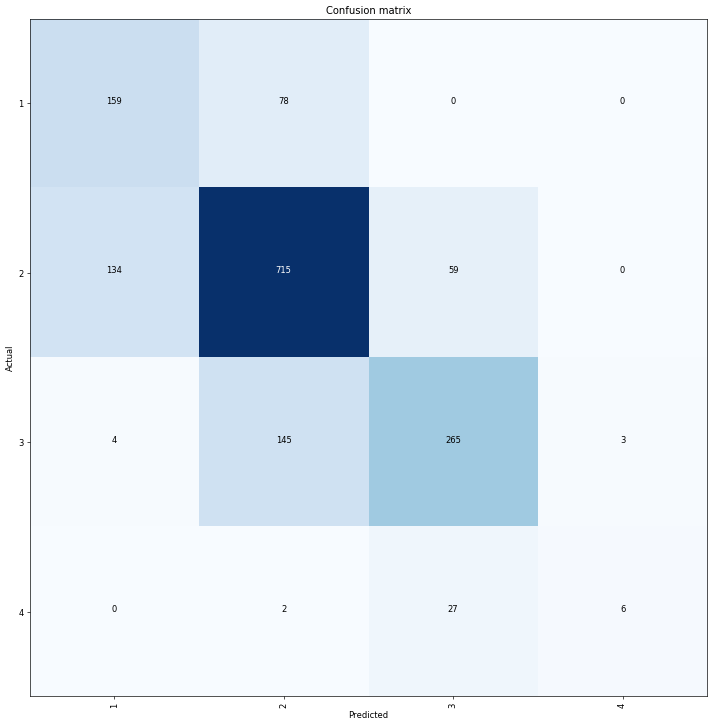

In [33]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Testing with Test Data

In [13]:
testPath = '/home/santhosr/Documents/Birad/ProcessedData/FullRes_Test/'

In [14]:
testData = (ImageItemList.from_folder(testPath).random_split_by_pct(0.90,seed=40).label_from_folder().transform(get_transforms(),size=512).databunch(bs=20).normalize(trainData.stats))

100%|██████████| 1797/1797 [08:50<00:00,  3.21it/s]

Validation accuracy : 0.7161936560934892


In [23]:
# pred = learn.get_preds(data.valid_ds)
# target = pred[1].numpy()
# finalPred = np.argmax(pred[0].numpy(),1)
# accuracy_score(finalPred,target)




In [43]:
pred

[tensor([[1.2090e-03, 6.8980e-03, 1.6187e-01, 8.3002e-01],
         [3.3030e-04, 5.2553e-03, 1.6545e-01, 8.2897e-01],
         [1.6966e-04, 3.0392e-04, 1.3685e-02, 9.8584e-01],
         ...,
         [6.9407e-01, 2.9444e-01, 1.0524e-02, 9.6242e-04],
         [5.6478e-01, 4.3227e-01, 2.8284e-03, 1.2734e-04],
         [9.5384e-04, 6.1421e-03, 1.4367e-01, 8.4923e-01]]),
 tensor([3, 3, 3, 0, 3, 0, 3, 0, 3, 2, 1, 3, 3, 3, 0, 2, 2, 2, 2, 3, 3, 3, 3, 1,
         3, 1, 3, 0, 2, 3, 3, 3, 2, 0, 3, 3, 1, 3, 1, 0, 1, 2, 1, 0, 1, 1, 2, 2,
         0, 1, 1, 2, 3, 0, 1, 2, 0, 1, 1, 1, 3, 1, 2, 0, 2, 1, 0, 1, 3, 1, 1, 3,
         0, 3, 2, 0, 0, 2, 1, 0, 3, 3, 2, 0, 2, 3, 0, 0, 3, 3, 2, 1, 3, 1, 1, 0,
         2, 2, 3, 0, 2, 3, 3, 1, 2, 0, 2, 2, 3, 1, 0, 3, 2, 1, 2, 2, 0, 3, 3, 0,
         1, 0, 1, 1, 1, 2, 0, 3, 0, 0, 2, 3, 3, 3, 1, 1, 2, 1, 2, 2, 3, 1, 2, 1,
         0, 3, 0, 3, 3, 2, 2, 1, 1, 3, 3, 2, 3, 3, 2, 2, 2, 0, 0, 1, 2, 0, 2, 0,
         2, 0, 3, 0, 0, 2, 2, 1, 3, 0, 2, 3, 1, 0, 1, 1, 0, 3, 

### Processing Pred Files

In [40]:
def getRaceAccuracy(fileName):
    
    df = pd.read_csv(fileName)
    
    df['Race'] = df['patientID'].apply(lambda x : truth[truth.DummyID==int(x)]['Medview_Race'].values[0] )
    df['Age'] = df['patientID'].apply(lambda x : truth[truth.DummyID==int(x)]['Age'].values[0] )
    
    raceList = list(dict(df.Race.value_counts()).keys())
    
    for i in range(len(raceList)):
    
        total = len(df[df.Race==raceList[i]])
        correct = len(df[(df.Race==raceList[i]) & (df.target==df.pred2) ] )
        acc = np.round(correct/total,3)
    
        print("Race :{} Total : {} Accuracy : {}".format(raceList[i], total, acc))

In [42]:
getRaceAccuracy('/home/santhosr/Documents/Birad/FastAI/MultiModelRuns/PredFiles/model_resnet_RS_id9_acc793_loss466.csv')

Race :African American Total : 1367 Accuracy : 0.49
Race :White Total : 344 Accuracy : 0.5
Race :Other Total : 38 Accuracy : 0.395
Race :Hispanic Latino/White Total : 20 Accuracy : 0.45
Race :Asian Total : 14 Accuracy : 0.071
Race :Unknown Total : 14 Accuracy : 0.286


In [70]:
from numpy.random import choice

In [71]:
choice(700,350,replace=False,seed=123)

TypeError: choice() got an unexpected keyword argument 'seed'

In [81]:
np.random.seed(123)
choice(700,5,replace=False)

array([ 57, 478, 597, 689, 647])

In [82]:
choice(700,5,replace=False)

array([268, 555, 221, 310, 218])

In [83]:
choice(700,5,replace=False)

array([165, 480, 497, 571, 650])